In [2]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.circuit.library import EfficientSU2
from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import NumPyMinimumEigensolver, VQE, SamplingVQE
from qiskit.primitives import Sampler,StatevectorSampler
from qiskit.primitives import Estimator 
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.result import QuasiDistribution

import numpy as np
from time import time
from IPython.display import clear_output
import datetime
import matplotlib.pyplot as plt
import pylab

In [8]:
num_assets = 25 #assets encoded as qubits
q = 0.5         #risk factor      
budget = 80     #max number of assets for any given combination
seed = 132     

stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(1955,11,5),   
                 end=datetime.datetime(1985,10,26),  
                 seed=seed)
data.run()

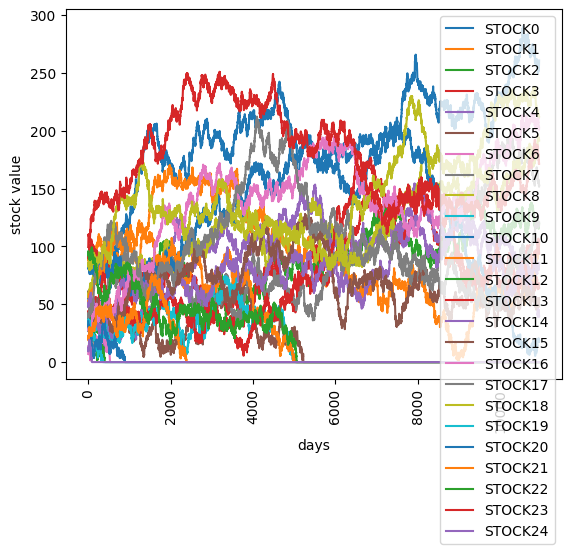

In [9]:
# Let's plot our finanical data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

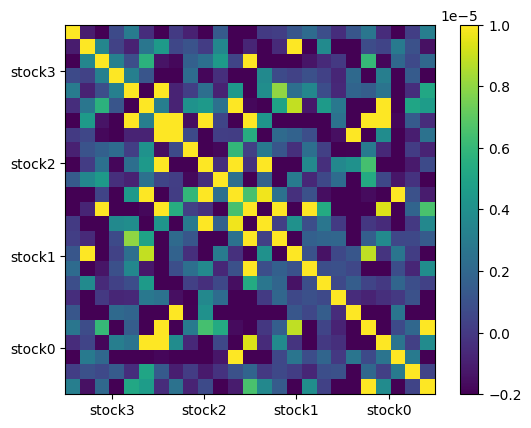

In [10]:
mu = data.get_period_return_mean_vector() 
sigma = data.get_period_return_covariance_matrix() #Returns the covariance matrix of the four assets
fig, ax = plt.subplots(1,1)
im = plt.imshow(sigma, extent=[-1,1,-1,1])
x_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
y_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
ax.set_xticks([-0.75,-0.25,0.25,0.75])
ax.set_yticks([0.75,0.25,-0.25,-0.75])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.colorbar()
plt.clim(-0.000002, 0.00001)
plt.show()

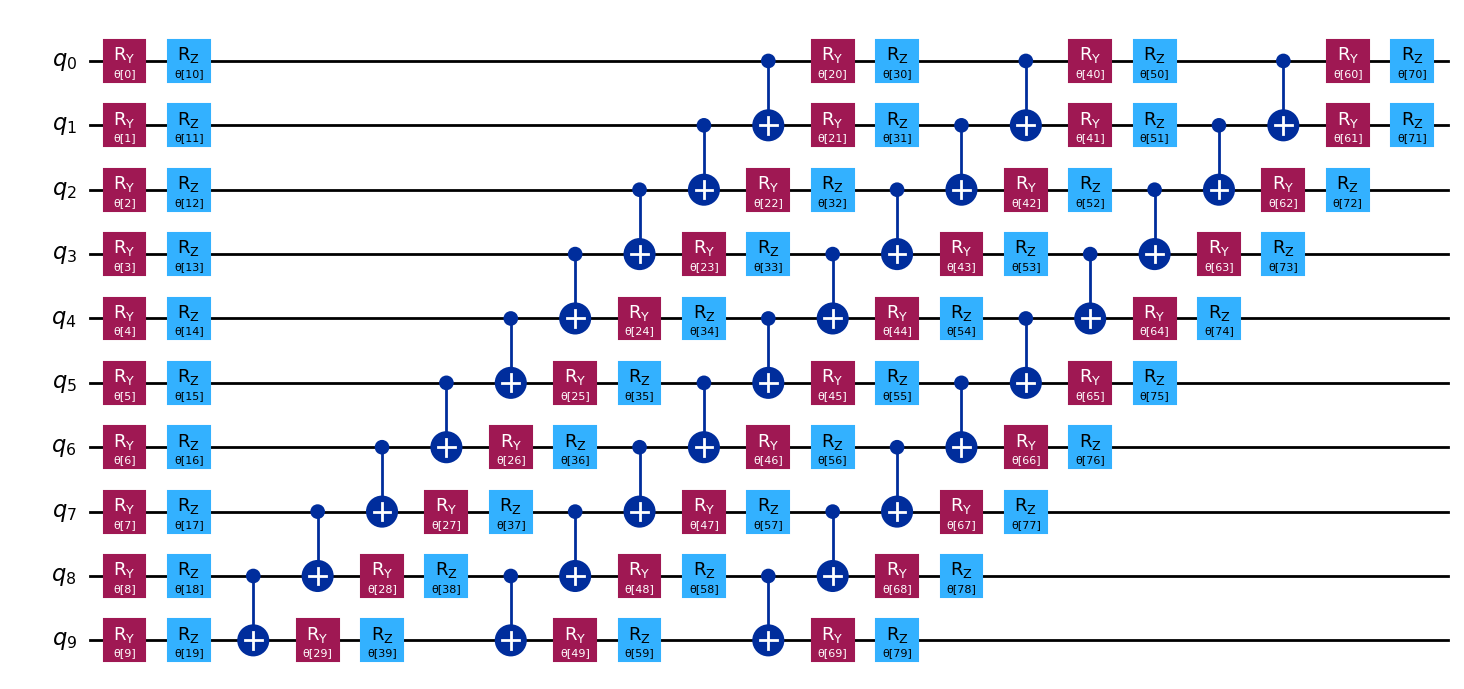

In [6]:
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget, bounds=None)
qp = portfolio.to_quadratic_program()

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

ansatz = EfficientSU2(num_assets)
#ansatz.decompose().draw("mpl", style="iqp")

In [11]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)

fval=0.0009144215351782185, x_0=1.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=1.0, x_6=1.0, x_7=1.0, x_8=1.0, x_9=1.0, status=INFEASIBLE


In [66]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

In [12]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

c:\Users\kamel\.conda\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\kamel\.conda\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Convergence of minimum energy')

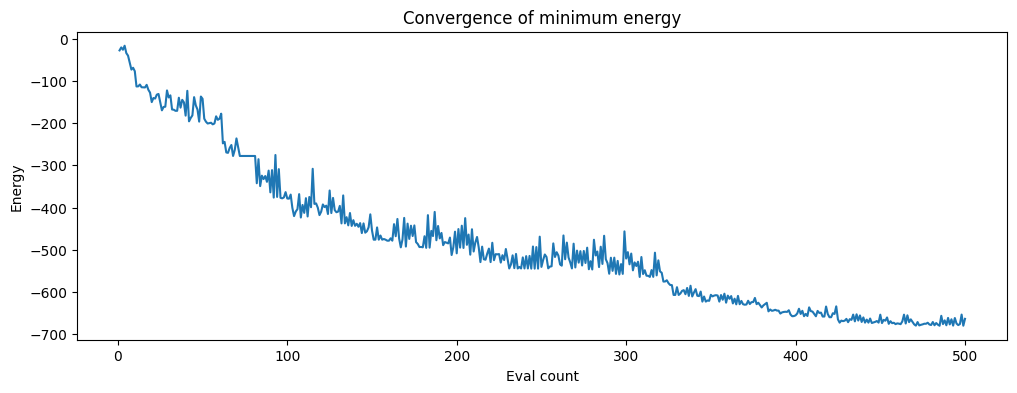

In [13]:
counts = []
values = []

ansatz = EfficientSU2(num_assets)
ansatz.decompose().draw("mpl", style="iqp")

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=cobyla,callback=store_intermediate_result)

svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence of minimum energy")